In [1]:
import os
from dotenv import load_dotenv
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import psycopg2
from scipy.sparse import hstack,csr_matrix,issparse
import textstat

In [3]:
import re
import string
import nltk

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [5]:
from sklearn.model_selection import cross_val_score
from sklearn.svm import LinearSVC

In [6]:
from sklearn.metrics import classification_report,ConfusionMatrixDisplay, accuracy_score,f1_score

In [7]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Nandita\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [8]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Nandita\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [9]:
nltk.download("vader_lexicon")

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Nandita\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [10]:
from nltk.corpus import stopwords

In [11]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [12]:
import optuna

In [13]:
import optuna.visualization as vis

In [14]:
import plotly

In [15]:
load_dotenv()

True

In [16]:
DB_HOST = os.getenv("DB_HOST")
DB_PORT = os.getenv("DB_PORT")
DB_NAME = os.getenv("DB_NAME")
DB_USER = os.getenv("DB_USER")
DB_PASSWORD = os.getenv("DB_PASSWORD")

In [17]:
DATABASE_URL = f"postgresql+psycopg2://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}"

In [18]:
engine = create_engine(DATABASE_URL)

In [19]:
train_df = pd.read_sql("SELECT * FROM train_data", engine)

In [20]:
def clean_texts(col): 
    col = col.lower() 
    col = re.sub(r"\d+", " num ", col)  
    col = re.sub(r"[^\w\s!?]", "", col)  
    col = " ".join([word for word in col.split() if word not in stopwords.words('english')])  
    return col

In [21]:
def convert_to_tfidf_vectorizer(df, text_col, max_features=5000, ngram_range=(1,2)):
    df = df.copy()
    vectorizer = TfidfVectorizer(max_features=max_features, ngram_range=ngram_range)
    X_tfidf = vectorizer.fit_transform(df[text_col])
    
    return X_tfidf, vectorizer

In [22]:
def combine_features(X_tfidf, engineered_features):
    if not issparse(engineered_features):
        engineered_features = engineered_features.values
    
    return hstack([X_tfidf, engineered_features])

In [23]:
def text_features(df, text_col):
    df = df.copy()
    
    # Readability features
    df['flesch'] = df[text_col].apply(lambda x: textstat.flesch_reading_ease(str(x)))
    df['gunning_fog'] = df[text_col].apply(lambda x: textstat.gunning_fog(str(x)))
    
    # VADER features
    analyzer = SentimentIntensityAnalyzer()
    df['vader_neg'] = df[text_col].apply(lambda x: analyzer.polarity_scores(str(x))['neg'])
    df['vader_neu'] = df[text_col].apply(lambda x: analyzer.polarity_scores(str(x))['neu'])
    df['vader_pos'] = df[text_col].apply(lambda x: analyzer.polarity_scores(str(x))['pos'])
    df['vader_compound'] = df[text_col].apply(lambda x: analyzer.polarity_scores(str(x))['compound'])
    
    return df

In [24]:
train_df.head()

,id,subject,body,text,category,category_id
0,promotions_582,Anniversary Special: Buy one get one free,"As our loyal customer, get exclusive $60 off $...",Anniversary Special: Buy one get one free As o...,promotions,1
1,spam_1629,Your Amazon was used on new device,Your $5000 refund is processed. Claim: bit.ly/...,Your Amazon was used on new device Your $5000 ...,spam,3
2,spam_322,Re: Your Google inquiry,"Hi, following up about your Google application...","Re: Your Google inquiry Hi, following up about...",spam,3
3,social_media_80,Digital Ritual Experience Creation,Cross-cultural ceremony design. Join: virtualr...,Digital Ritual Experience Creation Cross-cultu...,social_media,2
4,forum_1351,"Your post was moved to ""Programming Help""","Trending: ""cooking"" (258 comments). View: supp...","Your post was moved to ""Programming Help"" Tren...",forum,0


In [25]:
train_df['combined_text_original'] = train_df['subject']+ "" + train_df['body']+ "" +train_df['text']

In [26]:
train_df['combined_text_normalized'] = train_df['combined_text_original'].apply(clean_texts)

In [27]:
X_tfidf_train,vectorizer = convert_to_tfidf_vectorizer(train_df,'combined_text_normalized', max_features=10000, ngram_range=(2,3)) 

In [28]:
df = train_df[['combined_text_original','combined_text_normalized','category_id']]

In [29]:
df = text_features(df,'combined_text_original')

In [30]:
df.columns

Index(['combined_text_original', 'combined_text_normalized', 'category_id',
       'flesch', 'gunning_fog', 'vader_neg', 'vader_neu', 'vader_pos',
       'vader_compound'],
      dtype='object')

In [31]:
X_train = df[['flesch','gunning_fog','vader_neg','vader_neu','vader_pos','vader_compound']]

In [32]:
X_input_train = combine_features(X_tfidf_train, X_train)

In [33]:
y_input_train = df['category_id']

In [34]:
def objective(trial):
   
    C = trial.suggest_float("C", 1e-2, 100, log=True)
    
    svc = LinearSVC(
        C=C,
        penalty="l2",
        max_iter=20000,
        multi_class="ovr",
        fit_intercept=True,
        random_state=42
    )
    
    
    score = cross_val_score(
        svc, X_input_train, y_input_train, cv=5, scoring="f1_macro", n_jobs=-1,verbose=1
    )
    
    return np.mean(score)

In [35]:
study = optuna.create_study(direction="maximize")

[I 2025-09-03 10:41:10,132] A new study created in memory with name: no-name-360e4122-6a6a-414e-a8e7-74d87d08eeaf


[I 2025-09-03 10:41:13,089] A new study created in memory with name: no-name-13e91e94-9c80-4bf2-abcc-1cd1b6862d0e
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  7.6min finished
[I 2025-09-03 10:48:53,164] Trial 0 finished with value: 0.9517227637194088 and parameters: {'C': 0.020804184694736248}. Best is trial 0 with value: 0.9517227637194088.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 13.5min finished
[I 2025-09-03 11:02:22,047] Trial 1 finished with value: 0.968139262485163 and parameters: {'C': 0.18687039551477158}. Best is trial 1 with value: 0.968139262485163.


Best parameters found: {'C': 0.18687039551477158}
Best CV F1-macro: 0.968139262485163


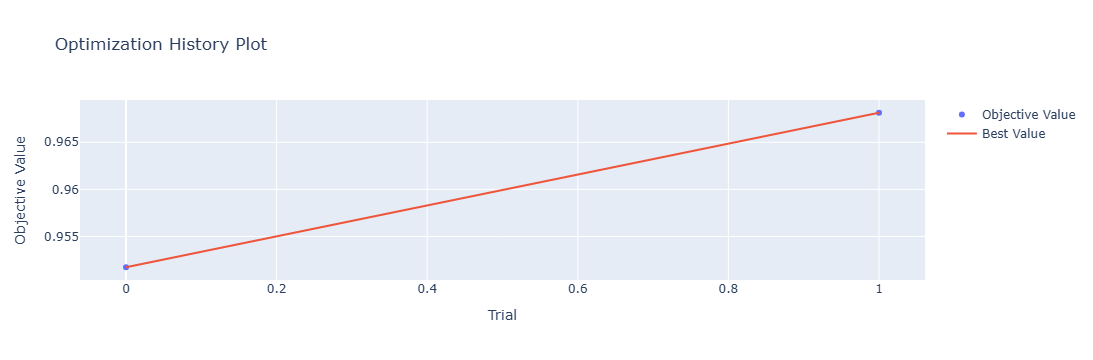

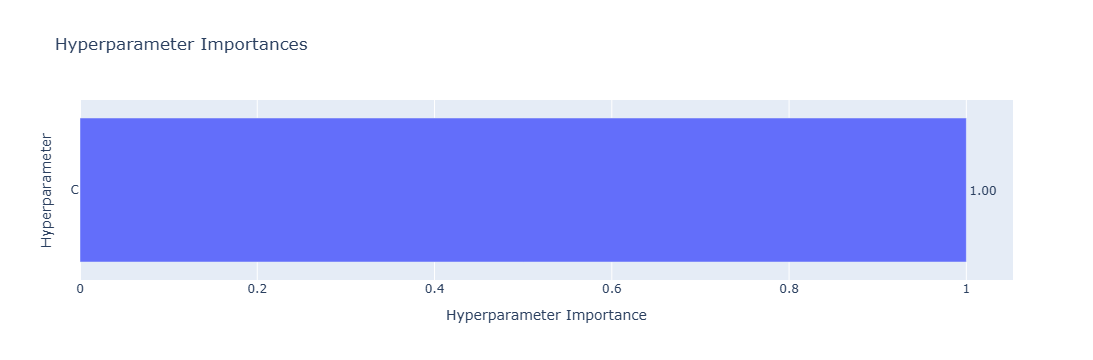

In [36]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20, timeout=900)  # 20 trials or 15 min max


print("Best parameters found:", study.best_params)
print("Best CV F1-macro:", study.best_value)


fig_history = vis.plot_optimization_history(study)
fig_history.show()


fig_importance = vis.plot_param_importances(study)
fig_importance.show()

In [37]:
best_C = study.best_params["C"]
final_clf = LinearSVC(
    C=best_C,
    penalty="l2",
    max_iter=20000,
    multi_class="ovr",
    fit_intercept=True,
    random_state=42
)
final_clf.fit(X_input_train, y_input_train)


,penalty,'l2'
,loss,'squared_hinge'
,dual,'auto'
,tol,0.0001
,C,0.18687039551477158
,multi_class,'ovr'
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,verbose,0
,random_state,42


In [38]:
import joblib

In [39]:
joblib.dump(final_clf, "linear_svc_optuna.pkl")

['linear_svc_optuna.pkl']

In [40]:
joblib.dump(vectorizer,"tfidf_vectorizer.pkl")

['tfidf_vectorizer.pkl']

In [50]:
test_df = pd.read_sql("SELECT * FROM test_data", engine)

In [51]:
test_df.head()

,id,subject,body,text,category,category_id
0,social_media_1558,Watch later: Recommended story,"Group update: ""Book Club"" posted video. Trendi...","Watch later: Recommended story Group update: ""...",social_media,2
1,social_media_505,News from groups you follow,"Group ""Tech Enthusiasts"" invited you. RSVP: pl...","News from groups you follow Group ""Tech Enthus...",social_media,2
2,forum_190,Two-Factor Authentication Enforcement Notice,Required for all accounts by Dec 1: security.f...,Two-Factor Authentication Enforcement Notice R...,forum,0
3,updates_1851,Security upgrade: 2FA enabled,Your monthly statement is available. View/down...,Security upgrade: 2FA enabled Your monthly sta...,updates,4
4,verify_code_1753,Verification PIN: 907472,Use 404583 as your verification code. Device: ...,Verification PIN: 907472 Use 404583 as your ve...,verify_code,5


In [62]:
df2 = test_df.copy()

In [63]:
df2['combined_text_original'] = df2['subject']+ "" + df2['body']+ "" +df2['text']

In [64]:
df2['combined_text_original'][1]

'News from groups you followGroup "Tech Enthusiasts" invited you. RSVP: platform.com/events/workshop.News from groups you follow Group "Tech Enthusiasts" invited you. RSVP: platform.com/events/workshop.'

In [65]:
df2['combined_text_normalized'] = df2['combined_text_original'].apply(clean_texts)

In [66]:
X_tfidf_test = vectorizer.transform(df2['combined_text_normalized'])

In [67]:
df2 = text_features(df2,'combined_text_original')

In [68]:
df2.columns

Index(['id', 'subject', 'body', 'text', 'category', 'category_id',
       'combined_text_original', 'combined_text_normalized', 'flesch',
       'gunning_fog', 'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound'],
      dtype='object')

In [69]:
X_test = df2[['flesch','gunning_fog','vader_neg', 'vader_neu', 'vader_pos','vader_compound']]

In [73]:
y_test_true = df2['category_id']

In [71]:
X_test_input = combine_features(X_tfidf_test, X_test)

In [75]:
y_test_pred = final_clf.predict(X_test_input)

In [77]:
print(classification_report(y_test_true,y_test_pred))

              precision    recall  f1-score   support

           0       0.97      0.95      0.96       450
           1       0.98      0.98      0.98       449
           2       0.96      0.98      0.97       449
           3       0.98      0.97      0.98       449
           4       0.95      0.98      0.96       449
           5       1.00      0.99      0.99       451

    accuracy                           0.97      2697
   macro avg       0.97      0.97      0.97      2697
weighted avg       0.97      0.97      0.97      2697



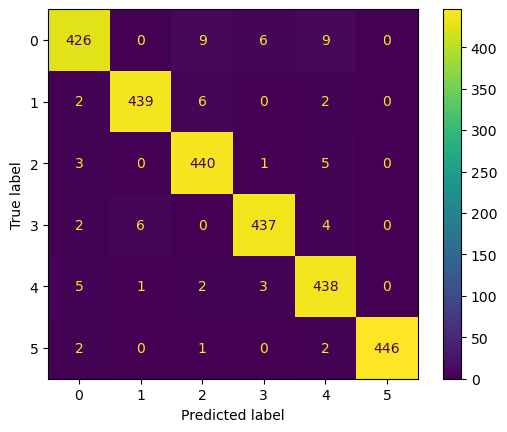

In [78]:
ConfusionMatrixDisplay.from_predictions(y_test_true, y_test_pred)
plt.show()

In [79]:
accuracy_score(y_test_true, y_test_pred)

0.9736744530960326